In [2]:
from pathlib import Path
import typing as t
import pandas as pd

# Define the directories
data_dir = Path("/lustre/scratch125/casm/team113da/projects/FUR/FUR_analysis/FUR_analysis_cat/human_comparison_figure/data/feb_2025_cohorts")
tcga_dir = data_dir / "TCGA"
china_pan_cancer_dir = data_dir / "china_pan_cancer"
msk_chord_dir = data_dir / "MSK-CHORD"
msk_impact_dir = data_dir / "MSK-IMPACT"

cohort_dirs: t.List[Path] = [tcga_dir, china_pan_cancer_dir, msk_chord_dir, msk_impact_dir]

def process_mutation_proportions_file(mutation_proportions_file: Path) -> pd.DataFrame:
    """
    Reads a mutation proportions file, extracts gene name and mutation proportion,
    and adds cohort and tumour type information extracted from the filename.
    """
    # Read the file assuming it is tab-delimited
    df = pd.read_csv(mutation_proportions_file, sep='\t')
    
    # Extract cohort_name and tumour_type from the file name.
    # Expecting file name format: cohort_name.tumour_type.mutation_proportions.txt
    file_name_parts = mutation_proportions_file.name.split('.')
    cohort_name = file_name_parts[0]
    tumour_type = file_name_parts[1]
    
    # Add these as new columns
    df["Cohort"] = cohort_name
    df["Tumour"] = tumour_type
    
    # Convert the Freq column to a decimal
    df["Freq"] = df["Freq"].str.replace('<', '').str.replace('>', '').str.rstrip('%').astype(float) / 100
    
    # Select only the desired columns
    df = df[["Cohort", "Tumour", "Gene", "Freq"]]
    return df

def process_cohort_dir(cohort_dir: Path) -> pd.DataFrame:
    """
    Process all mutation proportions files in a cohort directory and return a concatenated DataFrame.
    """
    # Get all files matching the pattern
    mutation_proportions_files = list(cohort_dir.glob("*.mutation_proportions.txt"))
    df_list = []
    
    for file in mutation_proportions_files:
        df_file = process_mutation_proportions_file(file)
        df_list.append(df_file)
    
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        return pd.DataFrame(columns=["Cohort", "Tumour", "Gene", "Freq"])

# Process all cohort directories and combine results into a single DataFrame
all_dfs = [process_cohort_dir(cohort_dir) for cohort_dir in cohort_dirs]
cbioportal_mutation_proportions_df = pd.concat(all_dfs, ignore_index=True)

cbioportal_mutation_proportions_df.head()


,Cohort,Tumour,Gene,Freq
0,tcga,glioma,PGLYRP4,0.007
1,tcga,glioma,ITSN1,0.015
2,tcga,glioma,SLA2,0.007
3,tcga,glioma,PTPDC1,0.007
4,tcga,glioma,CAPNS1,0.007


In [3]:
maf_dir = Path("/lustre/scratch125/casm/team113da/projects/FUR/FUR_analysis/FUR_analysis_cat/human_comparison_figure/data/fur_mafs")

# Get a list of the FUR MAF files
fur_mafs = list(maf_dir.glob('*.maf'))

# Create a list of dataframes to store the data
dataframes = []

# Create a dictionary to map study IDs to their respective cancer type
STUDY_ID_TO_TUMOUR_TYPE_DICT = {
    "6555_2711": "lung_adenocarcinoma",
    "6711_2820": "cscc",
    "6712_2822": "oscc",
    "6841_2964": "meningioma",
    "6864_2965": "pancreatic_carcinoma",
    "6945_3142": "cholangiocarcinoma",
    "6973_2987": "osteosarcoma",
    "6982_3135": "b_cell_lymphoma",
    "6990_3065": "mammary_carcinoma",
    "7040_3064": "basal_cell_carcinoma",
    "7097_3073": "colorectal_carcinoma",
    "7098_3140": "glioma"
}

T_CELL_LYMPHOMA_SAMPLES = ['CATD0572a', 'CATD0574a', 'CATD0575a',
                'CATD0578a', 'CATD0579a', 'CATD0580a', 
                'CATD0581a', 'CATD0585a', 'CATD0587a',
                'CATD0588a', 'CATD0592a', 'CATD0593a',
                'CATD0596a', 'CATD0598a', 'CATD0601a',
                'CATD0603a', 'CATD0606a', 'CATD0608a',
                'CATD0610a', 'CATD0678a', 'CATD0679a',
                'CATD0680a', 'CATD0682a', 'CATD0683a', 
                'CATD0684a', 'CATD0687a', 'CATD0721a',
                'CATD0722a', 'CATD0724a']


# Read in the data from each file
for file in fur_mafs:
    # Get the study ID from the file name
    study_id = file.stem.split('.')[0].split('matched_')[1]
    # Skip the studies that are not in cBioPortal
    if study_id == '6713_2821':
        continue
    # Translate the study ID into a cancer type
    tumour_type = STUDY_ID_TO_TUMOUR_TYPE_DICT.get(study_id)
    # Read in the data
    df = pd.read_csv(file, sep='\t')
    # Add the cancer type to the data
    df['Tumour'] = tumour_type
    # If this is the lymphoma cohort, drop the t-cell samples
    if tumour_type == "lymphoma":
        df = df[~df["Sanger_DNA_ID"].isin(T_CELL_LYMPHOMA_SAMPLES)]
    # Append the dataframe to the dataframe list
    dataframes.append(df)

# Combine the dataframes
fur_combined_df = pd.concat(dataframes)

def calculate_mutation_proportion_from_maf_df(df):
    """
    Calculate the proportion of samples with a mutation in each gene across each cancer type,
    and add a 'Cohort' column with a constant value 'FUR'.

    Parameters:
        df (pd.DataFrame): DataFrame containing mutation data.
            It must include 'Hugo_Symbol', 'Tumour', 'Tumor_Sample_Barcode', and 'Gene'.

    Returns:
        pd.DataFrame: A DataFrame with columns 'Gene', 'Tumour', 'Freq', and 'Cohort'.
    """
    # Check if required columns exist
    required_columns = {'Hugo_Symbol', 'Tumour', 'Tumor_Sample_Barcode', 'Gene'}
    assert required_columns.issubset(df.columns), f"Missing required columns: {required_columns - set(df.columns)}"

    # Use 'Gene' column if 'Hugo_Symbol' is '-'
    df['Gene_Final'] = df['Hugo_Symbol'].where(df['Hugo_Symbol'] != '-', df['Gene'])

    # Count the total number of unique samples per cancer type
    total_samples_per_cancer = df.groupby('Tumour')['Tumor_Sample_Barcode'].nunique()

    # Count the number of unique samples with mutations for each gene in each cancer type
    mutated_samples = df.groupby(['Gene_Final', 'Tumour'])['Tumor_Sample_Barcode'].nunique()

    # Calculate the proportion of mutated samples
    proportions = mutated_samples / total_samples_per_cancer

    # Reset the index and prepare the final DataFrame
    result = proportions.reset_index()
    result.columns = ['Gene', 'Tumour', 'Freq']

    # Add the Cohort column with a constant value 'FUR'
    result['Cohort'] = 'FUR'
    
    # Optional: Reorder the columns if desired
    result = result[['Cohort', 'Gene', 'Tumour', 'Freq']]

    return result


fur_mutation_proportion_df = calculate_mutation_proportion_from_maf_df(fur_combined_df)

fur_mutation_proportion_df.head()

,Cohort,Gene,Tumour,Freq
0,FUR,ABI1,cholangiocarcinoma,0.035714
1,FUR,ABI1,cscc,0.033333
2,FUR,ABI1,mammary_carcinoma,0.021739
3,FUR,ABL1,b_cell_lymphoma,0.020833
4,FUR,ABL1,cholangiocarcinoma,0.071429


In [4]:
# Merge the cbioportal and FUR dataframes on 'Gene' and 'Tumour'
merged_df = pd.merge(
    cbioportal_mutation_proportions_df,
    fur_mutation_proportion_df,
    on=['Gene', 'Tumour'],
    how='inner',  # inner join to keep only matching genes/tumour types
    suffixes=('_cbio', '_fur')
)

print(merged_df.head())

  Cohort_cbio  Tumour     Gene  Freq_cbio Cohort_fur  Freq_fur
0        tcga  glioma     PTEN      0.060        FUR  0.142857
1        tcga  glioma     TP53      0.134        FUR  0.142857
2        tcga  glioma  TNFAIP3      0.007        FUR  0.142857
3        tcga  glioma    SETD2      0.022        FUR  0.285714
4        tcga  glioma   CDKN2C      0.007        FUR  0.142857


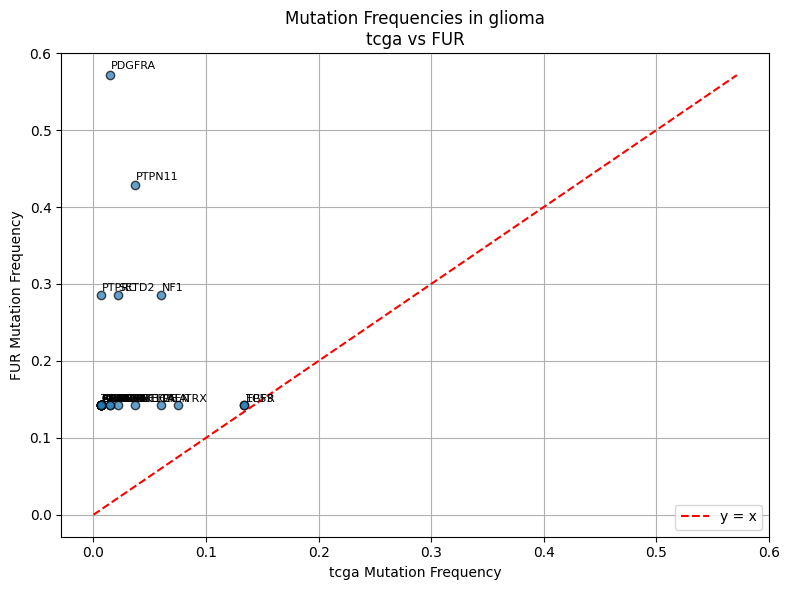

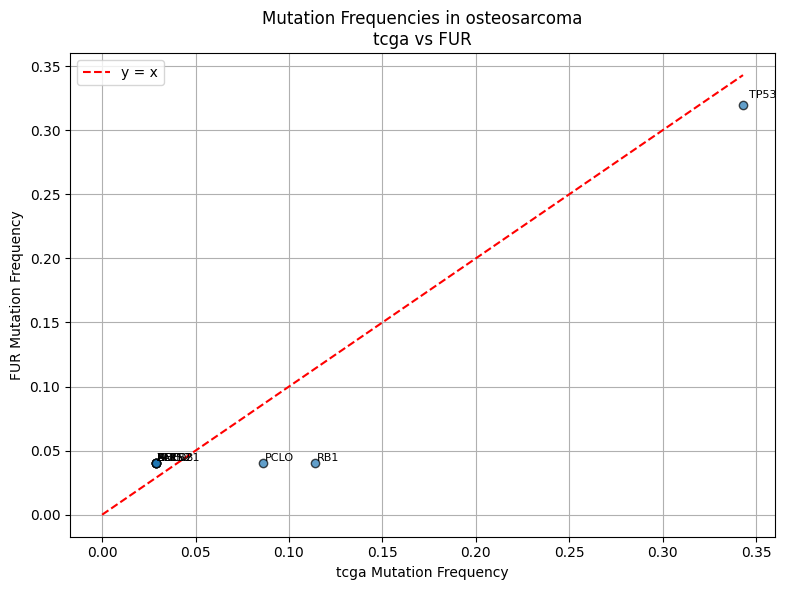

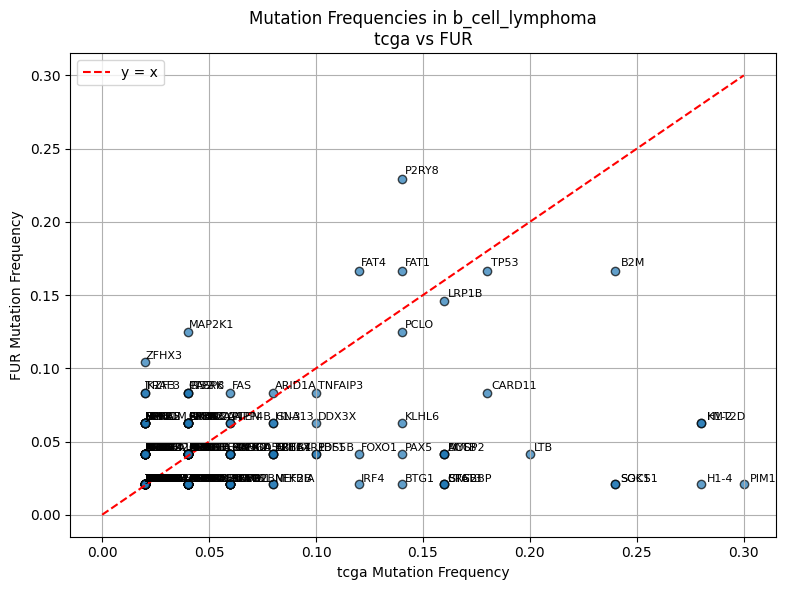

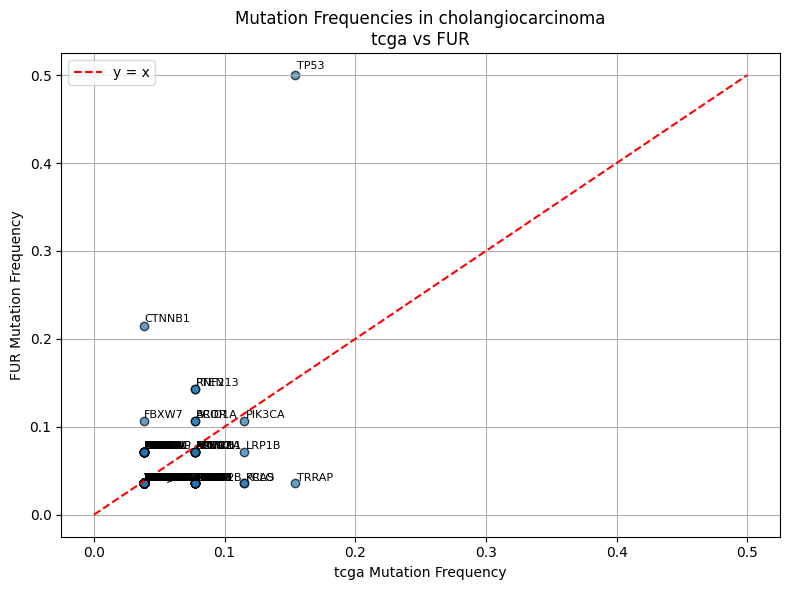

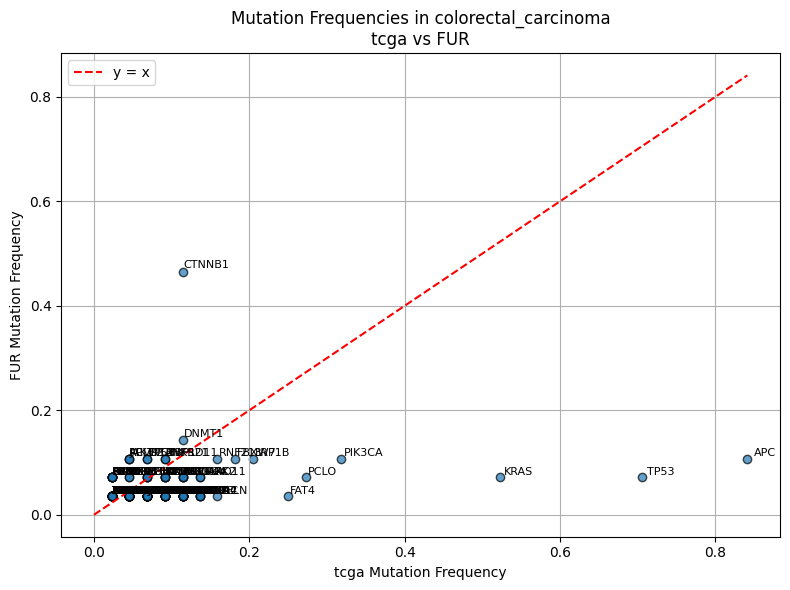

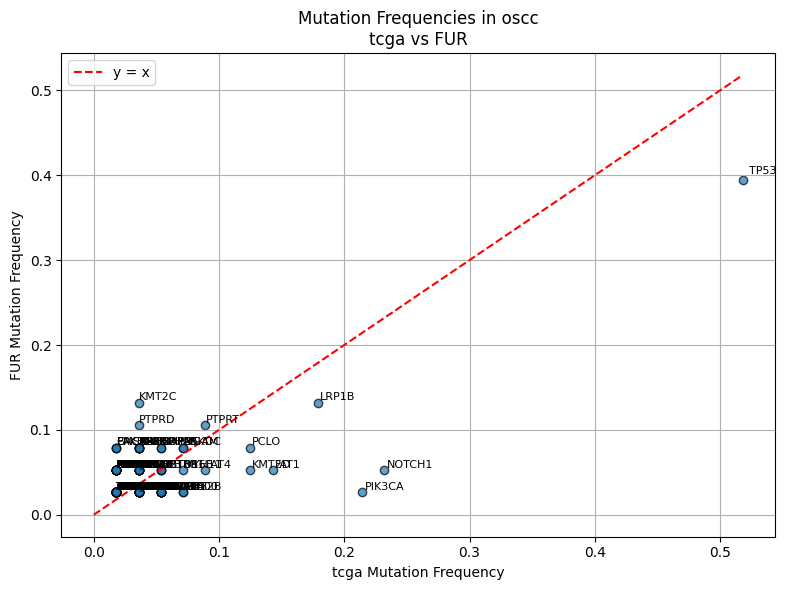

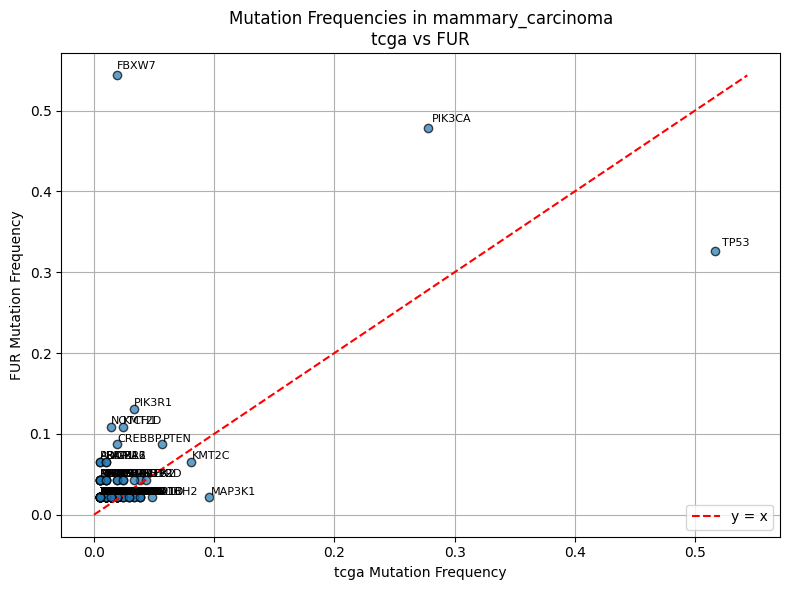

No matching genes for tcga in lung_carcinoma.


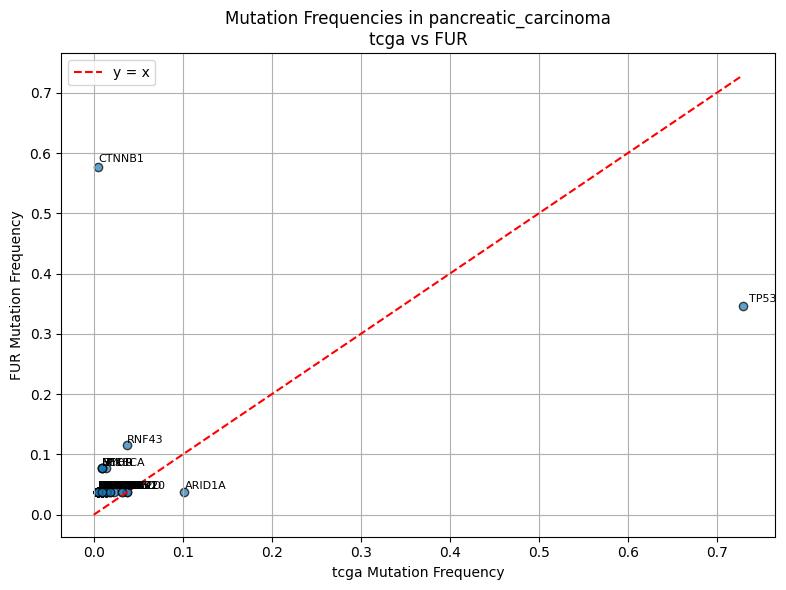

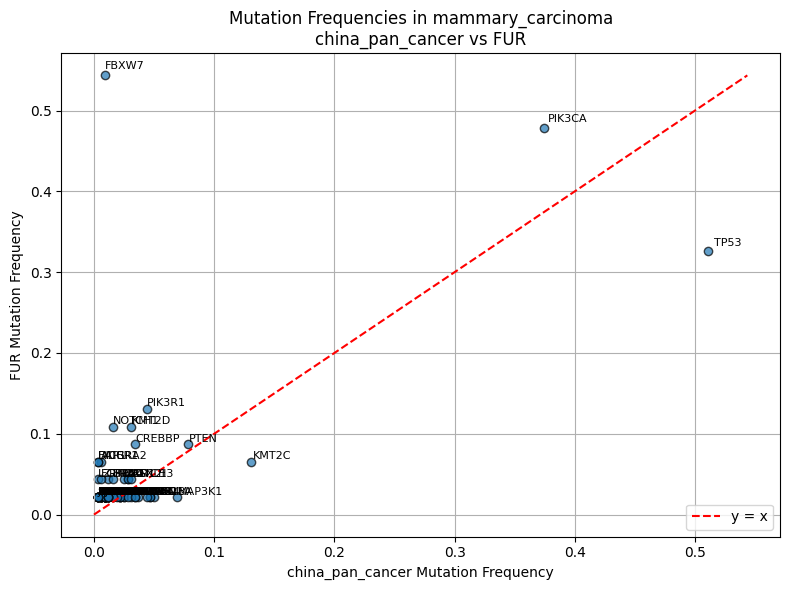

No matching genes for china_pan_cancer in lung_carcinoma.


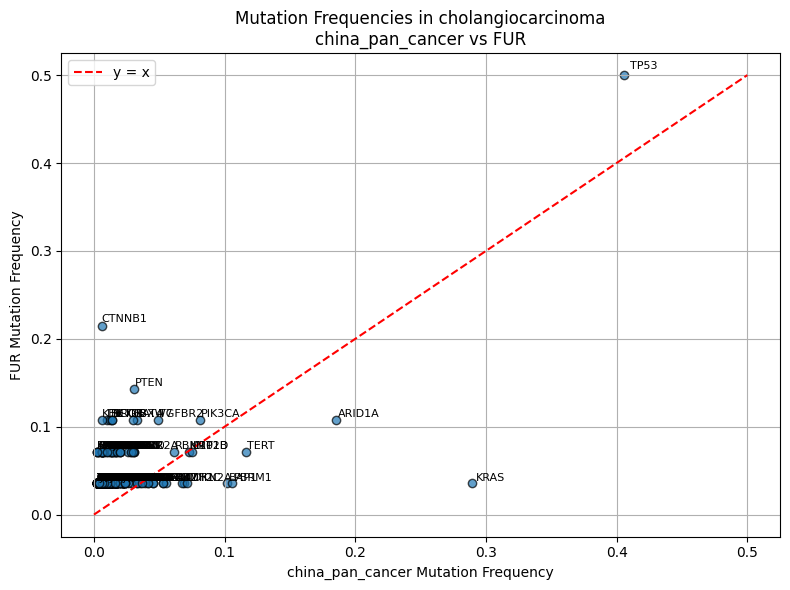

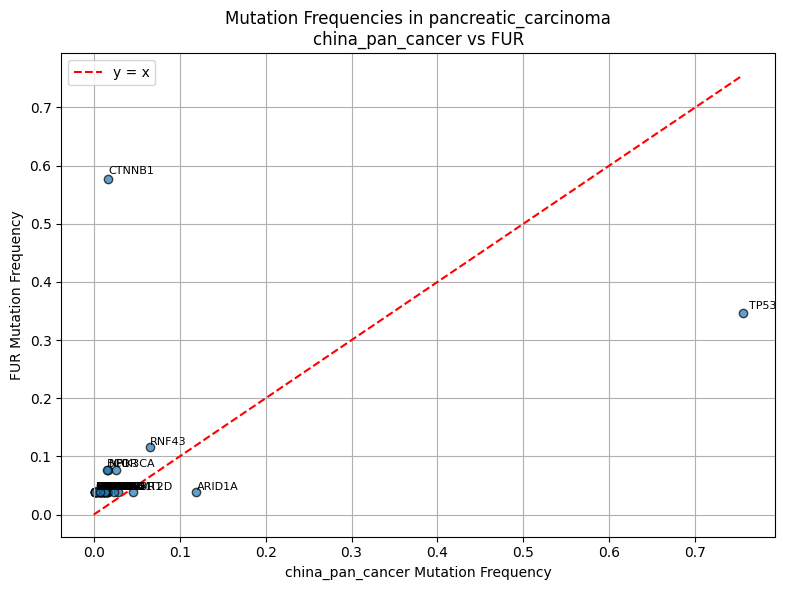

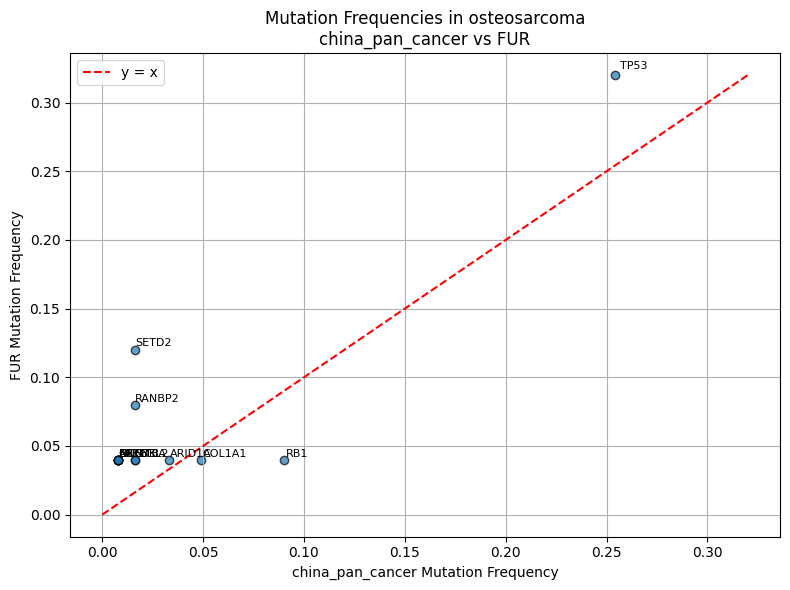

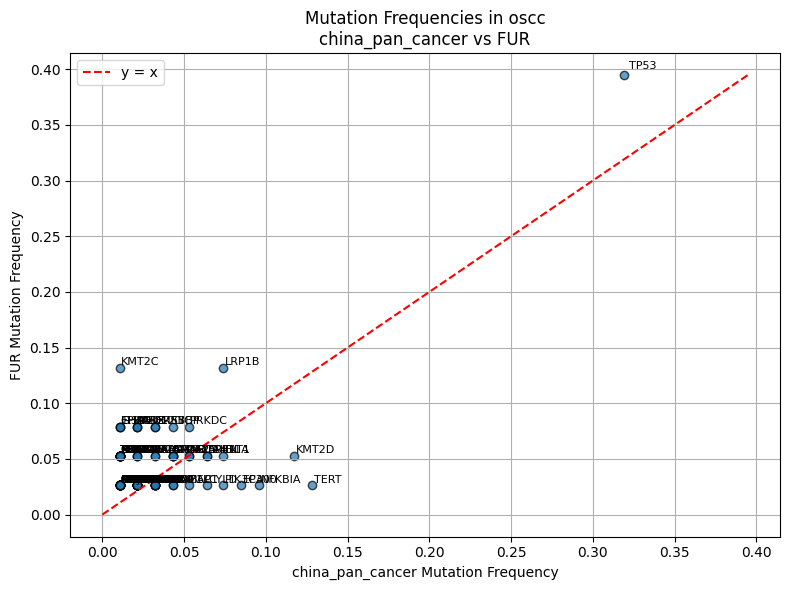

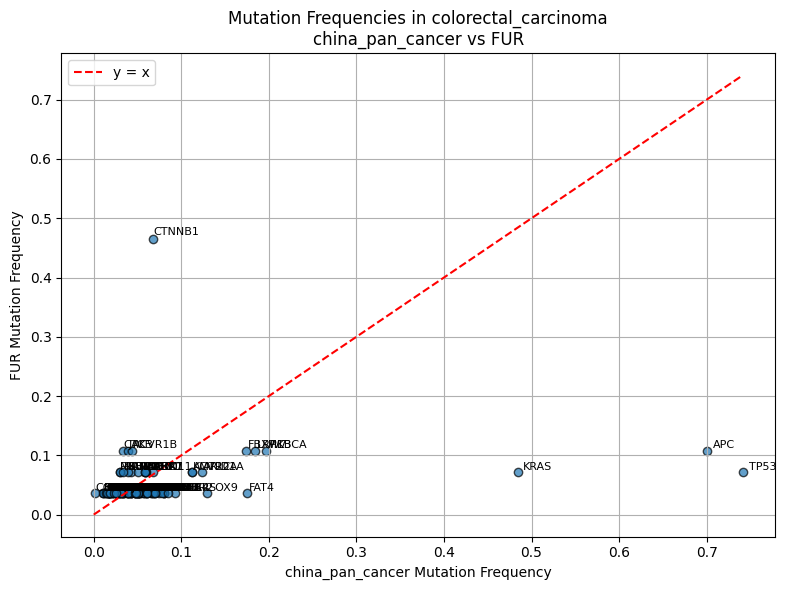

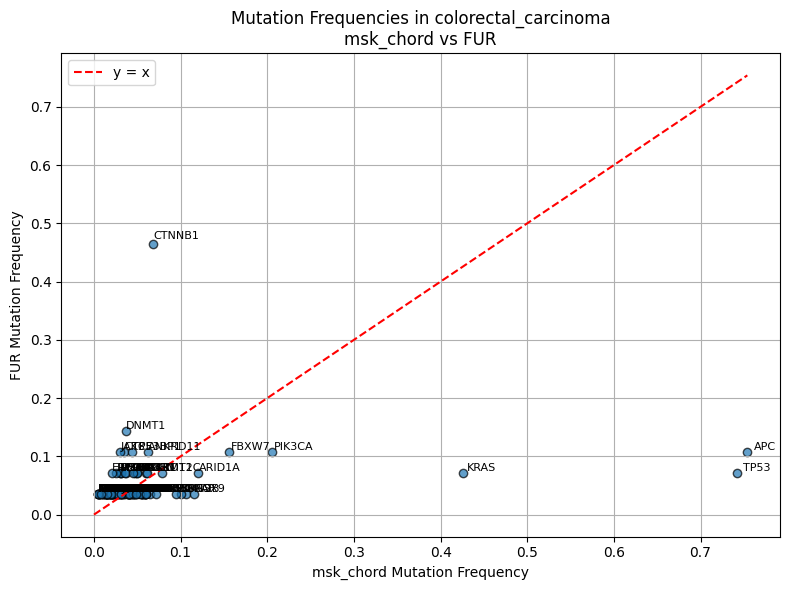

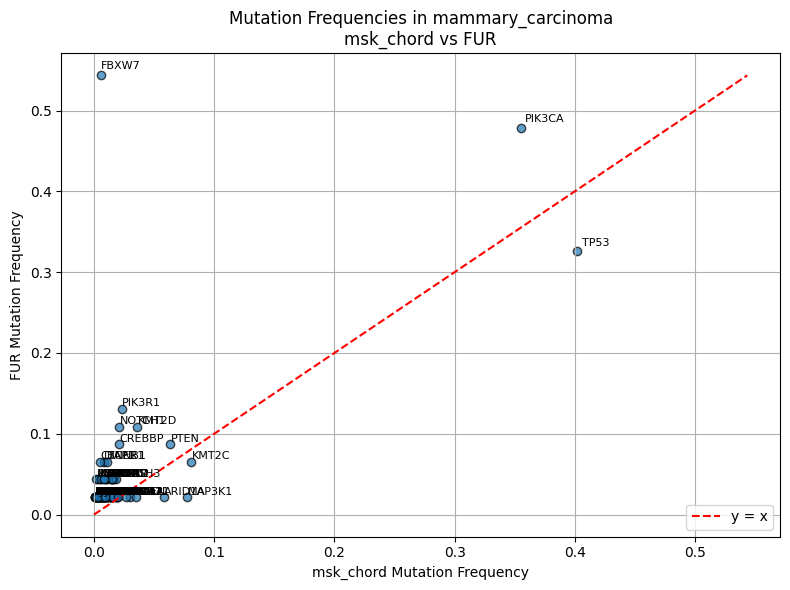

No matching genes for msk_chord in lung_carcinoma.


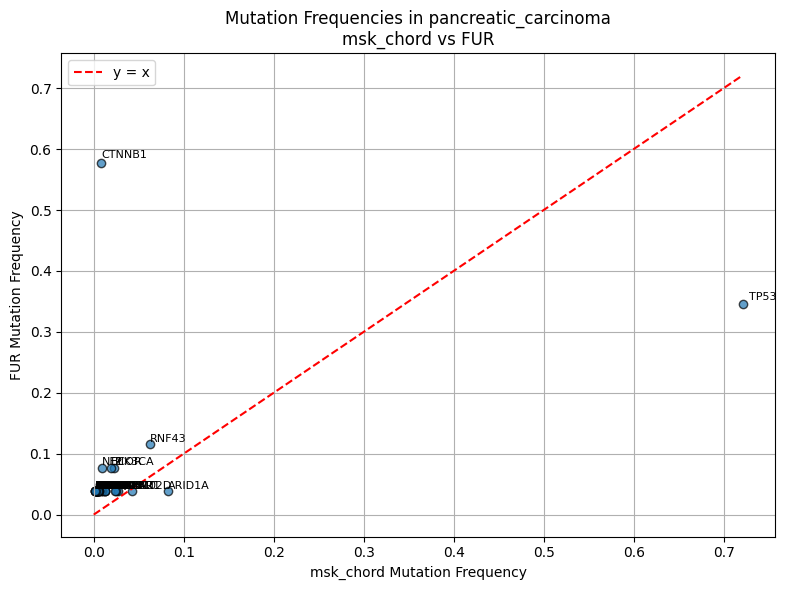

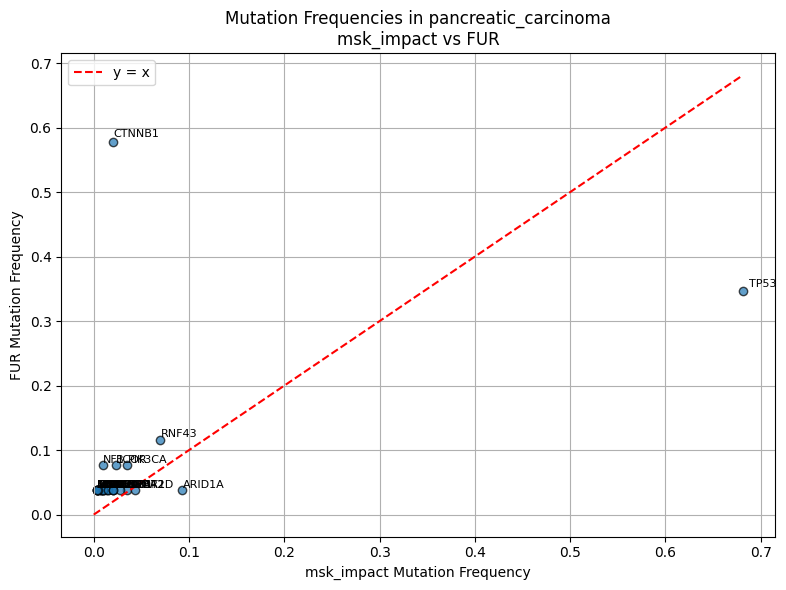

No matching genes for msk_impact in lung_carcinoma.


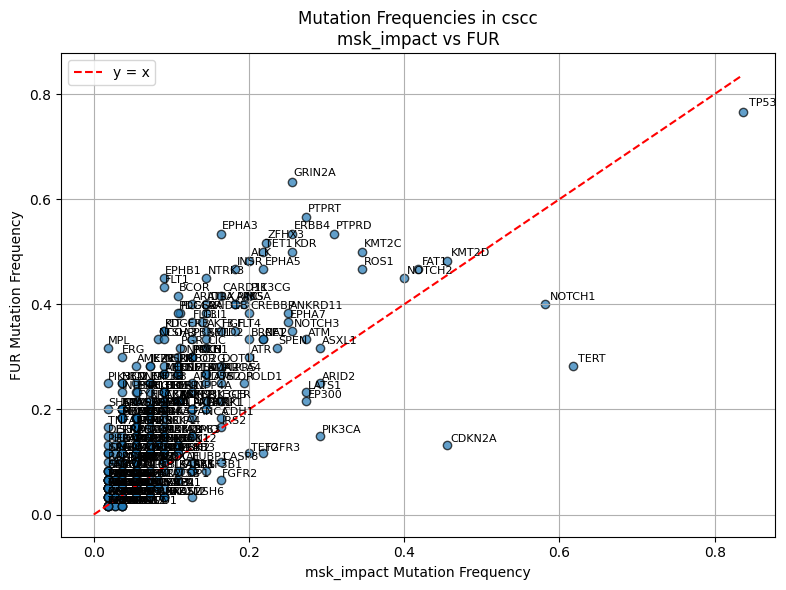

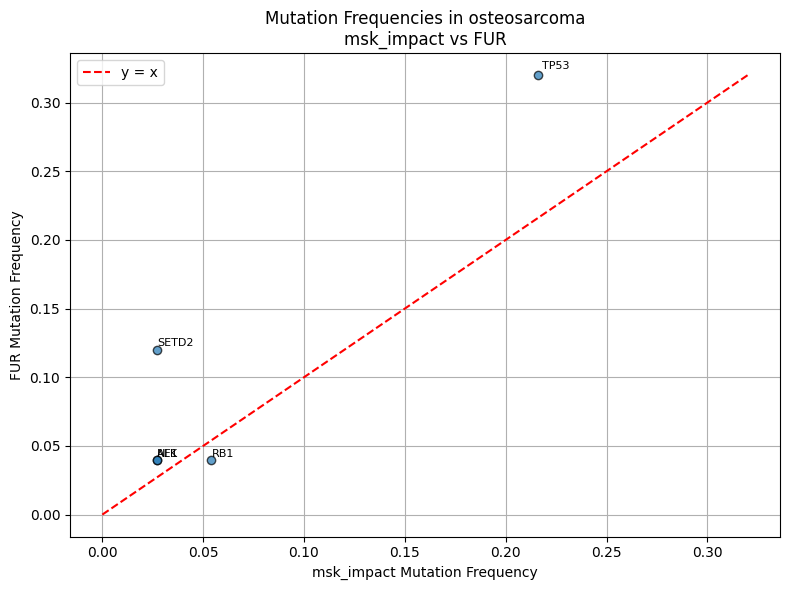

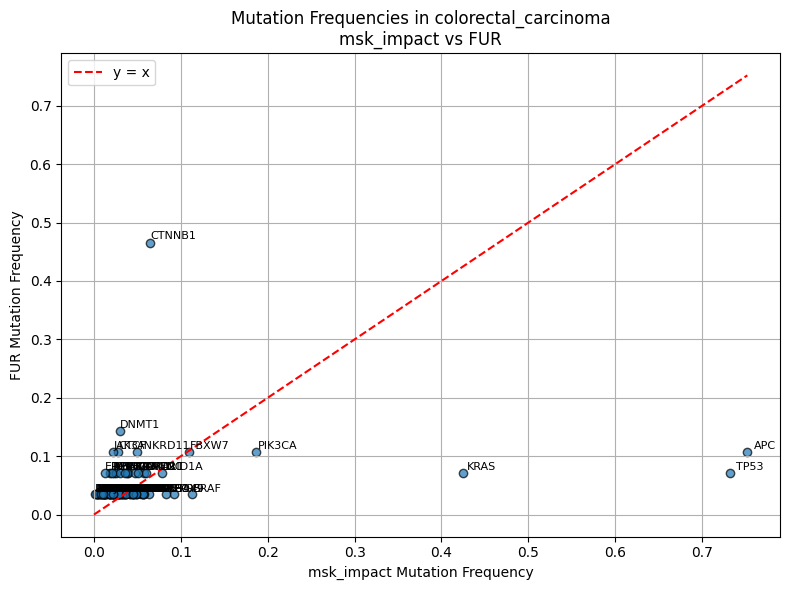

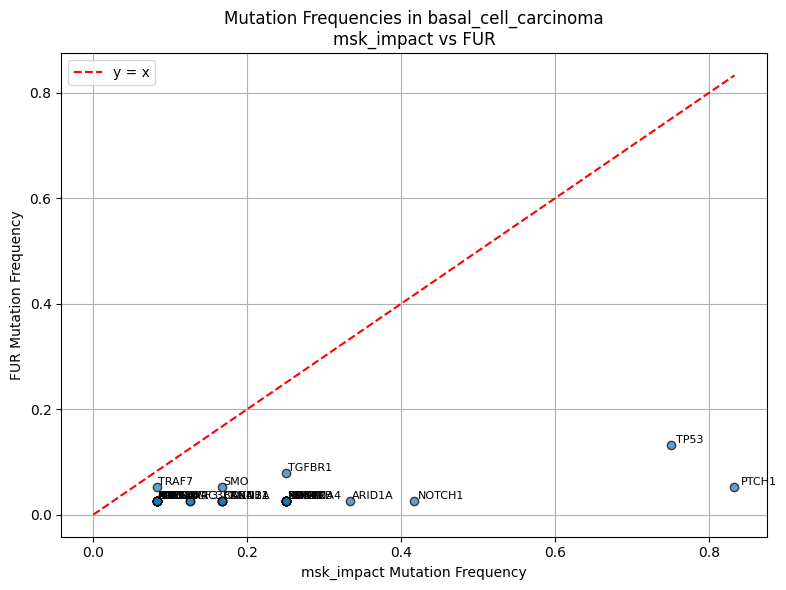

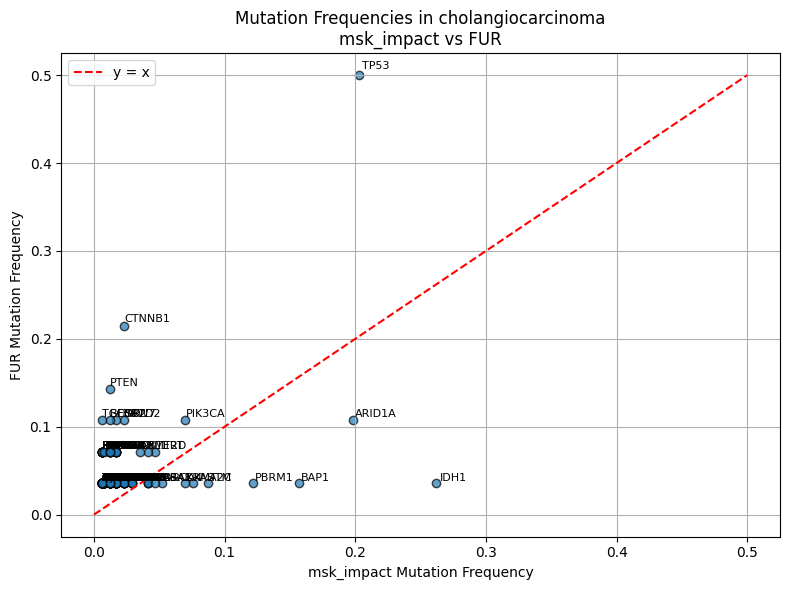

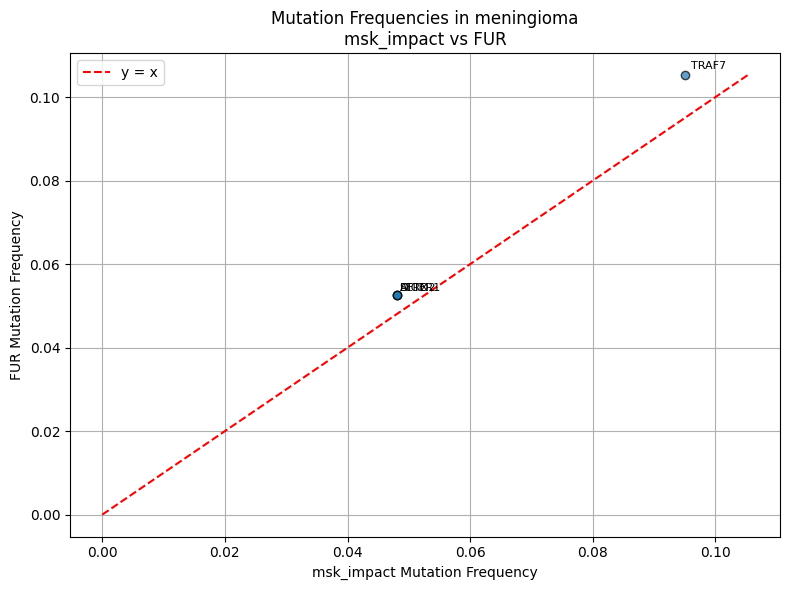

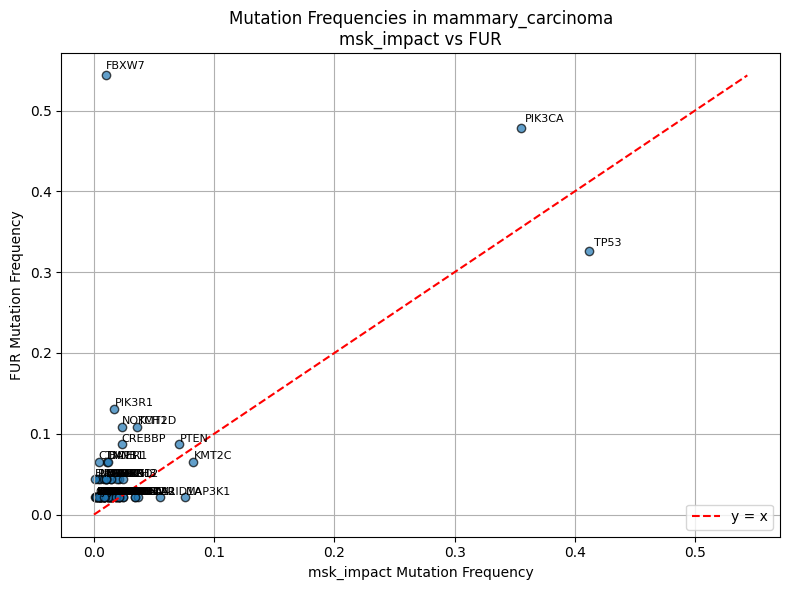

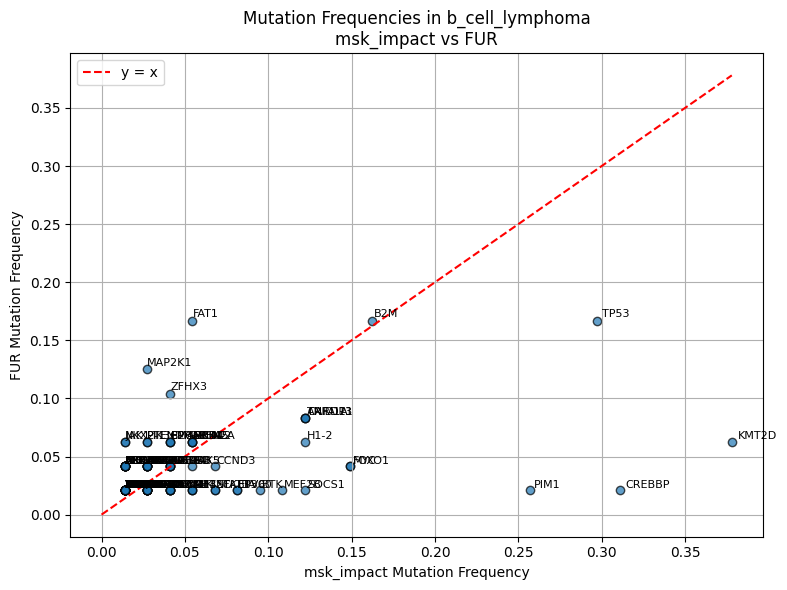

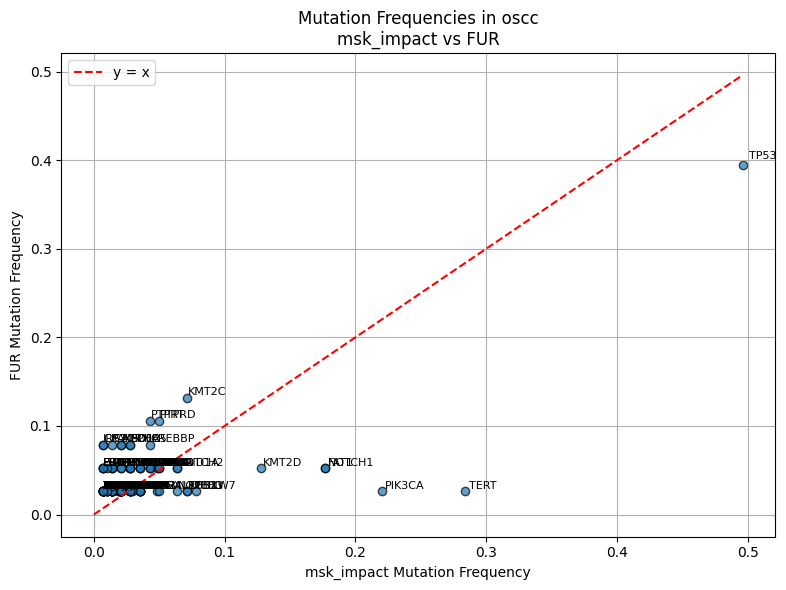

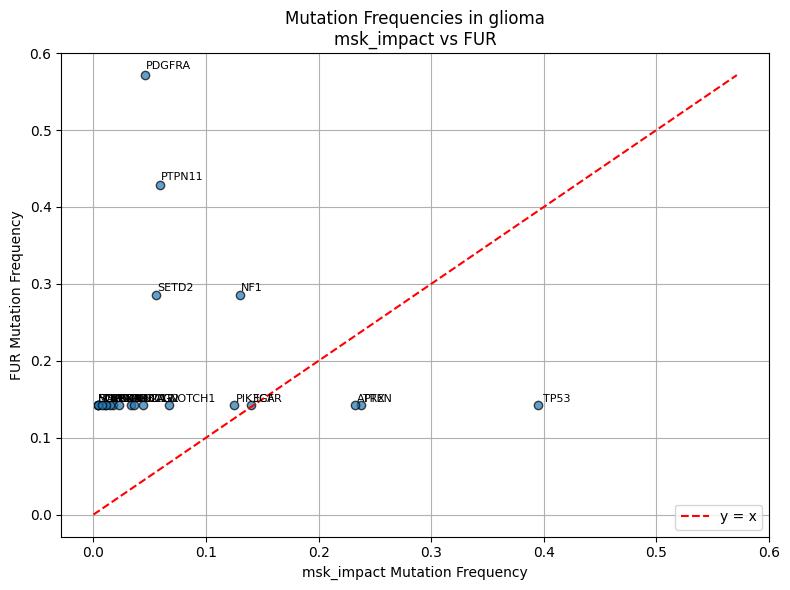

In [5]:
import matplotlib.pyplot as plt

# Loop over each unique cBioPortal cohort
for cbio_cohort in cbioportal_mutation_proportions_df['Cohort'].unique():
    # Subset the cBioPortal dataframe to the current cohort
    cbio_cohort_df = cbioportal_mutation_proportions_df[
        cbioportal_mutation_proportions_df['Cohort'] == cbio_cohort
    ]
    
    # Loop over each tumour type within this cohort
    for tumour in cbio_cohort_df['Tumour'].unique():
        # Subset cBioPortal data for the current tumour type
        cbio_subset = cbio_cohort_df[cbio_cohort_df['Tumour'] == tumour]
        # Subset FUR data for the same tumour type
        fur_subset = fur_mutation_proportion_df[fur_mutation_proportion_df['Tumour'] == tumour]
        
        # Merge on 'Gene' so that we compare the same gene in both datasets
        merged_df = pd.merge(cbio_subset, fur_subset, on="Gene", suffixes=('_cbio', '_fur'))
        
        # If there are no overlapping genes, skip plotting
        if merged_df.empty:
            print(f"No matching genes for {cbio_cohort} in {tumour}.")
            continue

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(merged_df['Freq_cbio'], merged_df['Freq_fur'], alpha=0.7, edgecolor='k')
        plt.xlabel(f'{cbio_cohort} Mutation Frequency')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(f'Mutation Frequencies in {tumour}\n{cbio_cohort} vs FUR')
        
        # Label each point with its gene name
        for _, row in merged_df.iterrows():
            # Slightly offset the text for clarity
            plt.text(row['Freq_cbio'] * 1.01, row['Freq_fur'] * 1.01, 
                     row['Gene'], fontsize=8, ha='left', va='bottom')
        
        # Plot a diagonal line for reference
        max_val = max(merged_df['Freq_cbio'].max(), merged_df['Freq_fur'].max())
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


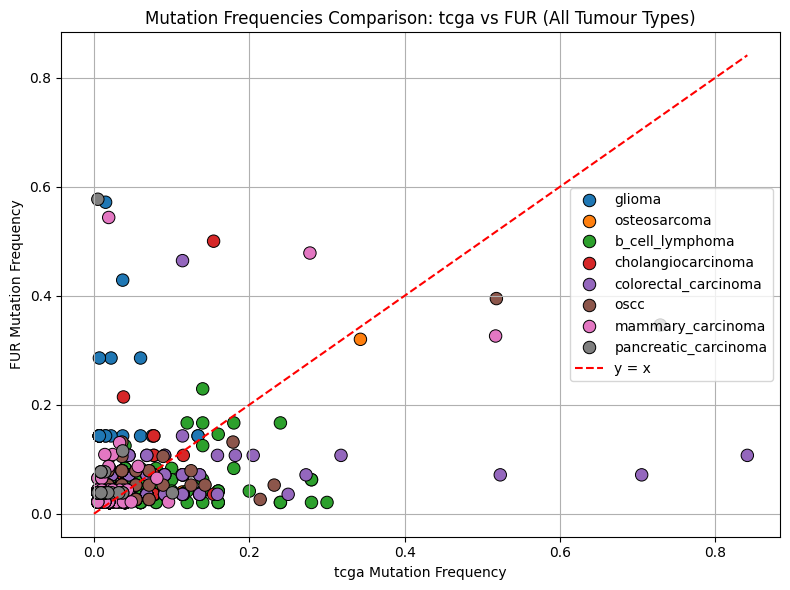

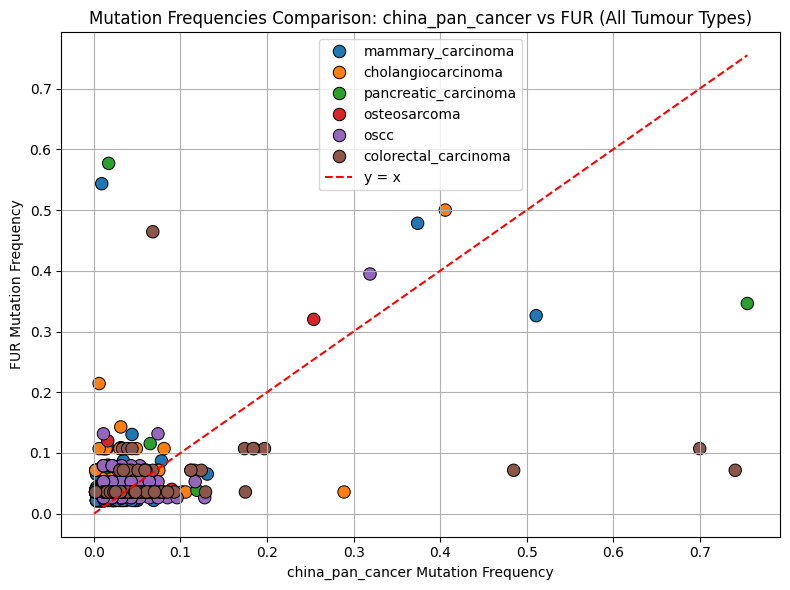

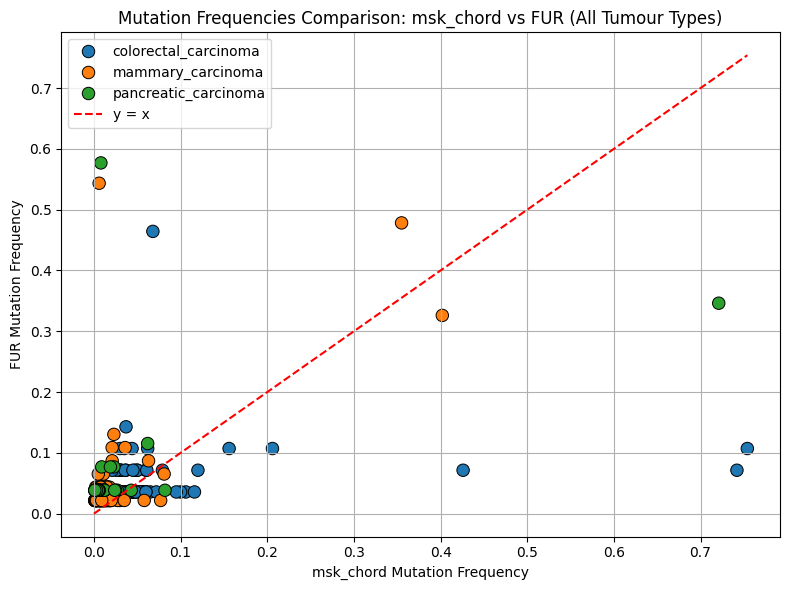

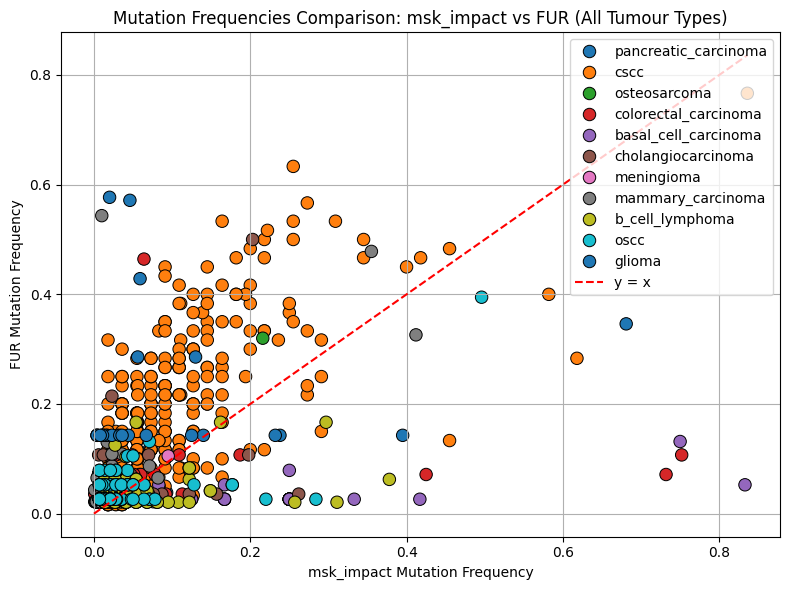

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop over each unique cBioPortal cohort
for cbio_cohort in cbioportal_mutation_proportions_df['Cohort'].unique():
    # Filter the cBioPortal data for this cohort
    cbio_cohort_df = cbioportal_mutation_proportions_df[
        cbioportal_mutation_proportions_df['Cohort'] == cbio_cohort
    ]
    
    # Create an empty list to collect merged data for all tumour types within this cohort
    merged_list = []
    
    # Loop over each tumour type in this cohort
    for tumour in cbio_cohort_df['Tumour'].unique():
        # Subset the cBioPortal data for the current tumour type
        cbio_subset = cbio_cohort_df[cbio_cohort_df['Tumour'] == tumour]
        # Subset the FUR data for the same tumour type
        fur_subset = fur_mutation_proportion_df[fur_mutation_proportion_df['Tumour'] == tumour]
        
        # Merge on both 'Gene' and 'Tumour' to preserve the tumour column
        merged_df = pd.merge(
            cbio_subset,
            fur_subset,
            on=["Gene", "Tumour"],
            suffixes=('_cbio', '_fur')
        )
        
        # Only add non-empty merges
        if not merged_df.empty:
            merged_list.append(merged_df)
    
    # Combine the merged data from all tumour types (if any)
    if merged_list:
        cohort_merged = pd.concat(merged_list, ignore_index=True)
        
        # Create a scatter plot with points colored by tumour type using seaborn
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=cohort_merged, 
            x='Freq_cbio', 
            y='Freq_fur', 
            hue='Tumour', 
            palette='tab10',
            s=80,
            edgecolor='k'
        )
        
        plt.xlabel(f'{cbio_cohort} Mutation Frequency')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(f'Mutation Frequencies Comparison: {cbio_cohort} vs FUR (All Tumour Types)')
        
        # Plot a reference diagonal (y = x) line
        max_val = max(cohort_merged['Freq_cbio'].max(), cohort_merged['Freq_fur'].max())
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No overlapping gene data found for {cbio_cohort}.")
